### Predicting house prices 🏡

#### Loading the Boston housing dataset

The dataset we’ll use has relatively few data points: only 506, split between 404 training samples and 102 test samples. And each feature in the input data (for example, the crime rate) has a different scale. For instance, some values are proportions, which take values between 0 and 1; others take values between 1 and 12, others between 0 and 100, and so on.

In [1]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 1us/step


#### Preparing the data

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation.

In [2]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

#### Building the network

The network ends with a single unit and no activation (it will be a linear layer). This is a typical setup for scalar regression (a regression where you’re trying to predict a single continuous value).

In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

We compile the network with the mse loss function—mean squared error, the square of the difference between the predictions and the targets.

We’re also monitoring a new metric during training: mean absolute error (MAE).

#### Validating the approach using K-fold validation

But because we have so few data points we'll use f-fold validation. It consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K – 1 partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the K validation scores obtained.

In [4]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


Running this with num_epochs = 100 yields the following results:

In [5]:
all_scores

[2.0832943821897603,
 2.6841978767130636,
 2.5829576855838887,
 2.6529902951552136]

In [6]:
np.mean(all_scores)

2.5008600599104813

Let’s try training the network a bit longer: 500 epochs.

#### Saving the validation logs at each fold

To keep a record of how well the model does at each epoch, you’ll modify the training loop to save the per-epoch validation score log.

In [7]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


#### Building the history of successive mean K-fold validation scores

In [8]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

#### Plotting validation scores, excluding the first 10 data points

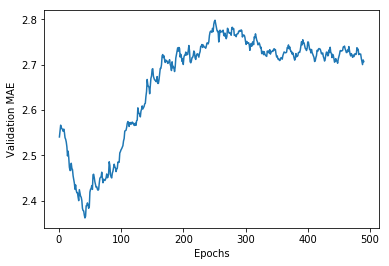

In [11]:
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after 80 epochs. Past that point, we start overfitting.

#### Training the final model

In [12]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 815us/step


Here’s the final result:

In [13]:
test_mae_score

2.6631562476064645